<a href="https://colab.research.google.com/github/JoslenysFreites/PP_2024-0_PROYECTO_FREITES/blob/main/PP_2024_0_JOKER_FREITES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Fractal original



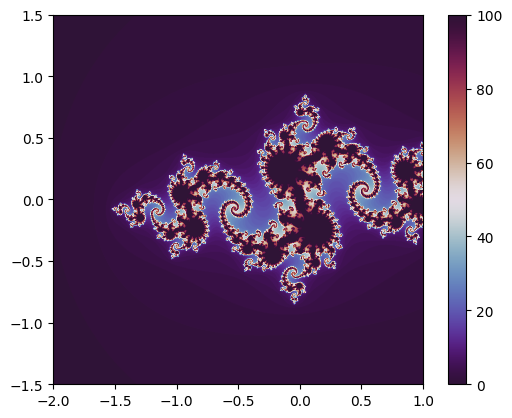


Modifica el fractal


interactive(children=(FloatSlider(value=-0.8, description='c_real:', max=2.0, min=-2.0, step=0.01), FloatSlide…

Button(description='Guardar Fractal', style=ButtonStyle())

Fractal guardado como fractal.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files  # Importar el módulo files de Google Colab para descargar archivos
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED
from threading import Lock, Condition
from ipywidgets import interact, FloatSlider, IntSlider, Button, Dropdown  # Importar los widgets interactivos de IPython
import os

class fractalJulia:
    def __init__(self, ancho, altura, max_iteraciones):
        self.ancho = ancho  # Ancho de la imagen del fractal
        self.altura = altura  # Altura de la imagen del fractal
        self.max_iteraciones = max_iteraciones  # Número máximo de iteraciones para calcular el fractal
        self.output = np.zeros((altura, ancho), dtype=int)  # Matriz para almacenar el fractal generado
        self.lock = Lock()  # mutex compartido para controlar el acceso al recurso compartido
        self.condicion = Condition()  # Variable de condición para coordinar los hilos
        self.tareas_pendientes = altura  # Contador de tareas restantes

    def fractalJulia(self, c, z):
        n = 0
        while abs(z) <= 2 and n < self.max_iteraciones: #determinar si un punto complejo pertenee al conjunto de Julia
            z = z**2 + c  # Aplicar la función de iteración del conjunto de Julia
            n += 1
        return n

    def generar_fila(self, y):
        row = np.zeros(self.ancho, dtype=int) #Crear un array lleno de ceros
        for x in range(self.ancho):
            real = x * (3 / self.ancho) - 2  # Convertir el valor de x a una coordenada en el plano complejo
            imag = y * (3 / self.altura) - 1.5  # Convertir el valor de y a una coordenada en el plano complejo
            z = complex(real, imag)  # Convertir las coordenadas en un número complejo
            row[x] = self.fractalJulia(complex(self.c_real, self.c_imag), z)  # Calcular el valor del pixel
        # Actualizar la matriz de salida con la fila generada
        with self.lock: #Grantizar que la actualización de la matriz de salida sea atómica
            self.output[y] = row
            self.tareas_pendientes -= 1
            if self.tareas_pendientes == 0:
                # Si no quedan tareas restantes, notificar a los hilos esperando en la condición
                self.condicion.notify_all()

    def fractal_julia_paralelo(self, c_real, c_imag):
        self.c_real = c_real  # Establecer la parte real de la constante c
        self.c_imag = c_imag  # Establecer la parte imaginaria de la constante c
        with ThreadPoolExecutor() as executor:
            futures = []
            for y in range(self.altura):
                futures.append(executor.submit(self.generar_fila, y))  # Ejecutar generar_fila en paralelo
            wait(futures, return_when=ALL_COMPLETED)  # Esperar a que todas las filas se generen
            # Esperar hasta que todos los hilos hayan terminado
            with self.condicion:
                while self.tareas_pendientes > 0:
                    self.condicion.wait()

    def graficar_fractal(self, xlim=None, ylim=None, cmap='twilight_shifted'):
        # Visualizar el fractal generado utilizando matplotlib
        plt.imshow(self.output, cmap=cmap, extent=(-2, 1, -1.5, 1.5))  # Mostrar la imagen del fractal
        plt.colorbar()  # Mostrar la barra de colores
        if xlim is not None:
            plt.xlim(xlim)  # Establecer los límites en el eje x si se especifican
        if ylim is not None:
            plt.ylim(ylim)  # Establecer los límites en el eje y si se especifican
        plt.show()  # Mostrar la imagen

    def guardar_fractal(self, filename, cmap='twilight_shifted'):
        # Guardar el fractal generado como una imagen
        plt.imshow(self.output, cmap=cmap, extent=(-2, 1, -1.5, 1.5))  # Mostrar la imagen del fractal
        plt.colorbar()  # Mostrar la barra de colores
        plt.savefig(filename)  # Guardar la imagen en el archivo especificado
        plt.close()  # Cerrar la figura después de guardarla
        print(f"Fractal guardado como {filename}")  # Imprimir un mensaje indicando el nombre del archivo guardado

        # Descargar el archivo
        files.download(filename)  # Descargar el archivo utilizando el módulo files de Google Colab

# Crear una instancia de la clase fractalJulia
fractal = fractalJulia(800, 800, 100)

def actualizar_fractal(c_real, c_imag, max_iteraciones, cmap='twilight_shifted'):
    fractal.fractal_julia_paralelo(c_real, c_imag)  # Generar el fractal con los parámetros especificados
    fractal.graficar_fractal(cmap=cmap)  # Visualizar el fractal generado

# Definir valores iniciales para los controles de parámetros
c_real_inicial = -0.8
c_imag_inicial = 0.156
max_iteraciones_iniciales = 100

# Crear controles deslizantes para los parámetros
c_real_deslizante = FloatSlider(value=c_real_inicial, min=-2, max=2, step=0.01, description='c_real:')
c_imag_deslizante = FloatSlider(value=c_imag_inicial, min=-2, max=2, step=0.01, description='c_imag:')
max_iteraciones_deslizante = IntSlider(value=max_iteraciones_iniciales, min=10, max=1000, step=10, description='Max Iterations:')
cmap_desplegable = Dropdown(options=['twilight_shifted', 'viridis', 'plasma', 'inferno', 'magma'], value='twilight_shifted', description='Color Map:')

# Generar el fractal inicial con los valores iniciales de los parámetros
print("\n Fractal original\n")
actualizar_fractal(c_real_inicial, c_imag_inicial, max_iteraciones_iniciales)

# Interactuar con la función actualizar_fractal utilizando los controles deslizantes
print("\nModifica el fractal")
interact(actualizar_fractal, c_real=c_real_deslizante, c_imag=c_imag_deslizante, max_iteraciones=max_iteraciones_deslizante, cmap=cmap_desplegable)

# Botón para guardar el fractal
print("\n")
guardar_boton = Button(description="Guardar Fractal")
guardar_boton.on_click(lambda b: fractal.guardar_fractal("fractal.png", cmap_desplegable.value))
display(guardar_boton)  # Mostrar el botón interactivo en el notebook
